# Multiple Logistic Regression in Spark  - College Admission

### Overview
Predict college admission using Multiple Logistic Regression
 
### Builds on
None

### Run time
approx. 10-20 minutes

### Notes



In [286]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /home/ubuntu/spark
Spark config:
	 executor.memory=2g
	some_property=some_value
	spark.app.name=TestApp
	spark.master=local[*]
	spark.sql.warehouse.dir=/tmp/tmp89zdj0qd
	spark.submit.deployMode=client
	spark.ui.showConsoleProgress=true
Spark UI running on port 4043



## Step 1: College Admission Data

Let's look at the college admission data.  Here, we have some student test scores, GPA, and Rank, followed by whether the student was admitted or not.

```
|gre  |gpa  |rank |  admitted |
|-----------------------------|
|380  |3.61 | 3   |    no     |
|660  |3.67 | 1   |    yes    |
|800  |4.0  | 1   |    yes    |
|640  |3.19 | 4   |    yes    |
|520  |2.93 | 4   |    no     |
|760  |3.0  | 2   |    yes    |
```

In [290]:
# admissions = spark.read.csv("/data/college-admissions/admission-data.csv",\
#                             header=True, inferSchema=True)
# admissions.printSchema()
# admissions.show()
# admissions.count()

astros = spark.read.csv("/home/ubuntu/my-work/Astros.csv",\
                            header=True, inferSchema=True)
astros.printSchema()
astros.show()
astros.count()

root
 |-- Gm#: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- Tm: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- Opp: string (nullable = true)
 |-- W/L: string (nullable = true)
 |-- R: integer (nullable = true)
 |-- RA: integer (nullable = true)
 |-- Inn: integer (nullable = true)
 |-- W-L: string (nullable = true)
 |-- Rank: integer (nullable = true)
 |-- GB: string (nullable = true)
 |-- Win: string (nullable = true)
 |-- Loss: string (nullable = true)
 |-- Save: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- D/N: string (nullable = true)
 |-- Attendance: integer (nullable = true)
 |-- Streak: string (nullable = true)
 |-- Orig. Scheduled: string (nullable = true)

+---+----------------+--------+---+----+---+----+---+---+----+----+----+------+---------+---------+--------+----+---+----------+----------+---------------+
|Gm#|            Date|     _c2| Tm| _c4|Opp| W/L|  R| RA| Inn| W-L|Rank|   

162

## Basic Exploration

In [269]:
# see the data spread
admissions.groupBy("admit").count().show()

+-----+-----+
|admit|count|
+-----+-----+
|    1|   43|
|    0|   57|
+-----+-----+



In [270]:
## see each column 
admissions.describe().toPandas()

,summary,admit,gre,gpa,rank
0,count,100,100,100,100
1,mean,0.43,600.0,3.390699999999998,2.52
2,stddev,0.49756985195624304,124.46248065545332,0.3971877275408833,1.019803902718557
3,min,0,300,2.42,1
4,max,1,800,4.0,4


## Step 2: Prepare feature vector

We need to firstconvert the dataframe to spark, and then prepare the feature vector.


In [271]:
from pyspark.ml.feature import VectorAssembler

## TODO: Select all columns except for "admit" to be in features **
## Hint : select columns 'gpa', 'gre', 'rank'
assembler = VectorAssembler(inputCols=["gre", "gpa","rank"], outputCol="features")
featureVector = assembler.transform(admissions)

In [272]:
## TODO: Make a new column called "label" with same value as "admit"
## Hint : featureVector is 'admit'
featureVector = featureVector.withColumn("label",featureVector["admit"])
featureVector.show()

+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|380|3.61|   3|[380.0,3.61,3.0]|    0|
|    1|660|3.67|   3|[660.0,3.67,3.0]|    1|
|    1|800| 4.0|   1| [800.0,4.0,1.0]|    1|
|    0|640|3.19|   4|[640.0,3.19,4.0]|    0|
|    0|520|2.93|   4|[520.0,2.93,4.0]|    0|
|    1|760| 3.0|   2| [760.0,3.0,2.0]|    1|
|    0|560|2.98|   1|[560.0,2.98,1.0]|    0|
|    0|400|3.08|   2|[400.0,3.08,2.0]|    0|
|    0|540|3.39|   3|[540.0,3.39,3.0]|    0|
|    1|700|3.92|   2|[700.0,3.92,2.0]|    1|
|    1|800| 4.0|   4| [800.0,4.0,4.0]|    1|
|    0|440|3.22|   1|[440.0,3.22,1.0]|    0|
|    1|760| 4.0|   1| [760.0,4.0,1.0]|    1|
|    1|700|3.08|   2|[700.0,3.08,2.0]|    1|
|    1|700| 4.0|   1| [700.0,4.0,1.0]|    1|
|    0|480|3.44|   3|[480.0,3.44,3.0]|    0|
|    1|780|3.87|   4|[780.0,3.87,4.0]|    1|
|    0|360|2.56|   3|[360.0,2.56,3.0]|    0|
|    1|800|3.75|   2|[800.0,3.75,2.0]|    1|
|    0|540

## Step 3: Split Data into training and Test

We will split our data into training and test so we can see how it performs.

In [273]:
## TODO : Split the data into train and test 70%  and 30%
## Hint : 
##     - training split is 70%  --> 0.7
##     - testing split  is 30%  --> 0.3
(train, test) = featureVector.randomSplit([0.7,  0.3], seed=1)
#(train, test) = featureVector.randomSplit([???,  ???], seed=1)

## print out record count
print ("train dataset count : " , train.count())
print ("test dataset count : " , test.count())

print("training data set")
train.show(10)

print("test data set")
test.show(10)

train dataset count :  77
test dataset count :  23
training data set
+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|300|2.92|   4|[300.0,2.92,4.0]|    0|
|    0|360|2.56|   3|[360.0,2.56,3.0]|    0|
|    0|360|3.14|   1|[360.0,3.14,1.0]|    0|
|    0|380|2.91|   4|[380.0,2.91,4.0]|    0|
|    0|380|3.61|   3|[380.0,3.61,3.0]|    0|
|    0|400|3.05|   2|[400.0,3.05,2.0]|    0|
|    0|400|3.08|   2|[400.0,3.08,2.0]|    0|
|    0|400|3.31|   3|[400.0,3.31,3.0]|    0|
|    0|400|3.35|   3|[400.0,3.35,3.0]|    0|
|    0|440|2.48|   4|[440.0,2.48,4.0]|    0|
+-----+---+----+----+----------------+-----+
only showing top 10 rows

test data set
+-----+---+----+----+----------------+-----+
|admit|gre| gpa|rank|        features|label|
+-----+---+----+----+----------------+-----+
|    0|380|2.94|   3|[380.0,2.94,3.0]|    0|
|    0|400|3.65|   2|[400.0,3.65,2.0]|    0|
|    0|480|3.57|   2|[480.0,3.57,2.0


## Step 4: Run logistic regression

In [274]:
from pyspark.ml.classification import LogisticRegression

## TODO : set maxIter to 10
#lr = LogisticRegression(maxIter=???)
lr = LogisticRegression(maxIter=100, regParam=0.0, elasticNetParam=0.8)
lr.setThreshold(0.3)

## TODO : Fit the model on 'training' set
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.012775375783527821,3.5356627239979175,-0.4122002367452471]
Intercept: -18.712141689542694


**==> Q : Do any of your coefficients zero?  What is the implication?**  
If you see ZERO coefficients, try the following:
- increase the number of iterations and run again
- turn off regularization by setting `regparam=0`

## Step 5: Predict on Test data

In [275]:
## TODO : predict on 'test' data
predictions_test = lrModel.transform(test)
predictions_test.show()
# sample a few 0 and 1
predictions_test.sampleBy("prediction", fractions={0: 0.5, 1: 0.5}, seed=0).show()

+-----+---+----+----+----------------+-----+--------------------+--------------------+----------+
|admit|gre| gpa|rank|        features|label|       rawPrediction|         probability|prediction|
+-----+---+----+----+----------------+-----+--------------------+--------------------+----------+
|    0|380|2.94|   3|[380.0,2.94,3.0]|    0|[4.69925119348398...|[0.99098001050349...|       0.0|
|    0|400|3.65|   2|[400.0,3.65,2.0]|    0|[1.52122290702966...|[0.82071848928434...|       0.0|
|    0|480|3.57|   2|[480.0,3.57,2.0]|    0|[0.78204586226727...|[0.68612087650862...|       1.0|
|    0|500|2.97|   4|[500.0,2.97,4.0]|    0|[3.47233645448595...|[0.96989032514807...|       0.0|
|    0|500|3.31|   3|[500.0,3.31,3.0]|    0|[1.85801089158141...|[0.86506493276160...|       0.0|
|    0|520|3.29|   1|[520.0,3.29,1.0]|    0|[0.84881615690032...|[0.70031874541651...|       0.0|
|    0|540|3.81|   1|[540.0,3.81,1.0]|    0|[-1.2452359752491...|[0.22352590364091...|       1.0|
|    0|560|3.32|   4

## Step 6: Evaluate Model

In [276]:
trainingSummary = lrModel.summary

predictions_test = lrModel.transform(test)  # Hint : 'test'
predictions_train = lrModel.transform(train) #  Hint : 'train'

# we can also get this from trainingSummary
predictions_train = lrModel.summary.predictions

### 6.1 - Iterations and Objective History
**==> Q : how many iterations did we do?**  
- What does that tell you?
- Increase the total number of iterations from 50 to 100, Does it change the results?

In [277]:
## trainingSummary has an attribute called 'totalIterations'  
## Hint : use the TAB completion
print ("total iterations ", trainingSummary.totalIterations)

## you can uncomment this and see how the error is diminishing in each iteration
print("objectiveHistory:" , trainingSummary.objectiveHistory)
# for objective in trainingSummary.objectiveHistory:
#     print(objective)

total iterations  21
objectiveHistory: [0.6923880071472722, 0.6880886259241904, 0.672196221072143, 0.5948594012025606, 0.5876301322033568, 0.5750323586828426, 0.5566562426137645, 0.5108641660692963, 0.45081744911970073, 0.40343650404608616, 0.3869756573078817, 0.3849060833587043, 0.3848658435809512, 0.3846922090824694, 0.38462559261568147, 0.3846152697661423, 0.38461370175747533, 0.38461366902057487, 0.38461365306790524, 0.3846136529973662, 0.3846136529969225]


### 6.2 - accuracy

In [278]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.8181818181818182
Test set accuracy =  0.5652173913043478


### 6.3 Confusion Matrix

In [279]:
cm = predictions_test.groupBy('admit').pivot('prediction').count().na.fill(0).orderBy('admit')
cm.show()

+-----+---+---+
|admit|0.0|1.0|
+-----+---+---+
|    0|  8|  9|
|    1|  1|  5|
+-----+---+---+



[]

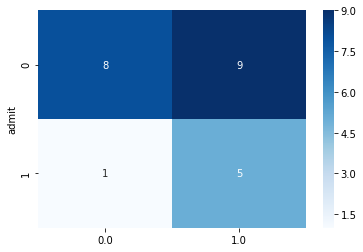

In [280]:
import seaborn as sns

cm_pd = cm.toPandas()
cm_pd.set_index("admit", inplace=True)
# print(cm_pd)

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm_pd, annot=True, cmap="Blues").plot()

### 6.4 :  ROC Curve & AUC

In [281]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# default metrics for BinaryClassificationEvaluator is 'areaUnderCurve'
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
# print ("default metrics : " ,evaluator.getMetricName())

# Area Under Curve is part of training summary
# use TAB completion :  trainingSummary.TAB
# we can get this from trainingSummary
print("AUC for training: " , trainingSummary.areaUnderROC)
# or
print("AUC for training: " , evaluator.evaluate(predictions_train))
print ("AUC for test : " , evaluator.evaluate(predictions_test))


AUC for training:  0.9040540540540541
AUC for training:  0.9040540540540541
AUC for test :  0.8431372549019608


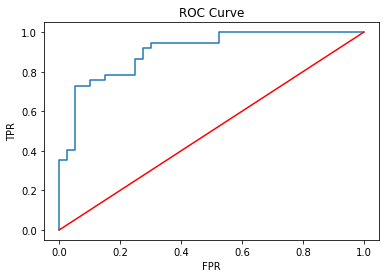

In [282]:
# ROC

%matplotlib inline
import matplotlib.pyplot as plt

roc_df = trainingSummary.roc.toPandas()

plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.plot([0.0, 1.0], [0.0, 1.0], 'r')

## Step 7: Run some predictions on new data

Let's take some new data, and run predictions on that.


In [283]:
import pandas as pd

newdata = pd.DataFrame({'gre' : [600, 700, 800], 
                        'gpa' : [4.0, 3.5, 3.2],
                        'rank': [1,   2,   3]}
             )
print(newdata)


## TODO: create spark dataframe from pandas dataframe
## Hint : input is 'newdata'
spark_newdata = spark.createDataFrame(newdata)

## TODO: transform the new data in order to get feature vectors
## Hint : spark_newdata
newfeatures = assembler.transform(spark_newdata)

lrModel.transform(newfeatures).show()

   gre  gpa  rank
0  600  4.0     1
1  700  3.5     2
2  800  3.2     3
+---+---+----+---------------+--------------------+--------------------+----------+
|gre|gpa|rank|       features|       rawPrediction|         probability|prediction|
+---+---+----+---------------+--------------------+--------------------+----------+
|600|4.0|   1|[600.0,4.0,1.0]|[-2.6835344398204...|[0.06395197099228...|       1.0|
|700|3.5|   2|[700.0,3.5,2.0]|[-1.7810404194289...|[0.14417471090802...|       1.0|
|800|3.2|   3|[800.0,3.2,3.0]|[-1.5856789438371...|[0.16999270806270...|       1.0|
+---+---+----+---------------+--------------------+--------------------+----------+



## Step 8: Experiment
Click on 'Cell --> RunAll' and watch the accuracy number below.  
See how it changes?  
Can you explain why?

In [284]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

print("Training set accuracy = " , evaluator.evaluate(predictions_train))
print("Test set accuracy = " , evaluator.evaluate(predictions_test))

Training set accuracy =  0.8181818181818182
Test set accuracy =  0.5652173913043478


### 8.1 - Why do you think the accuracy varies for each run?  

Try this, at Step-3, supply a seed parameter (can be any number) and do the run again.  
Do you see the accuracy varying now?  
Can you explain the behavior?

### 8.2 - Adjust regularization (lambda) parameter
Vary 'regparam' in **step 4** from 0.1 to 0.9.  
Do you see accuracy changing?

### 8.3 - Set threshold
We can setup 'threshold' in Step-4, as follows

```python
lr = LogisticRegression(maxIter=???, regParam=0.3, elasticNetParam=0.8)
lr.threshold = 0.7  # values between 0 and 1.0
```

Change the threshold and try a few runs.  See how the accuracy changes.

### 8.4 - Class discussion
How do you find the right 'lambda' ..etc values?  
Hint : lots of experimental runs :-) 

## Step 9 : Save Output
**TODO : Inspect the saved data**  
(Hint : you can open them in excel)

In [285]:
# save data to a csv file for inspection
predictions2 = predictions_test.select(['admit', 'gre', 'gpa', 'rank', 'prediction'])

## option1 : use Spark write function
## this works for big data (writes are distributed across cluster)
output_path1="college-admissions-predictions.out1"
predictions2.write.\
    option('header', 'true').\
    mode('overwrite').\
    csv(output_path1)
print("save 1 (spark)  to : ", output_path1)


## Option 2 : convert to Pandas dataframe and save
## This is good for small amount of data
output_path2= 'college-admissions-predictions.out2.csv'
predictions2.toPandas().to_csv(output_path2 )
print("save 2 (pandas) to : ", output_path2)

save 1 (spark)  to :  college-admissions-predictions.out1
save 2 (pandas) to :  college-admissions-predictions.out2.csv
